In [ ]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

In [ ]:
!apt-get update
!apt-get install -y iverilog

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5,139 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,840 kB]
Get:13 http://archive.ubuntu.com/ubunt

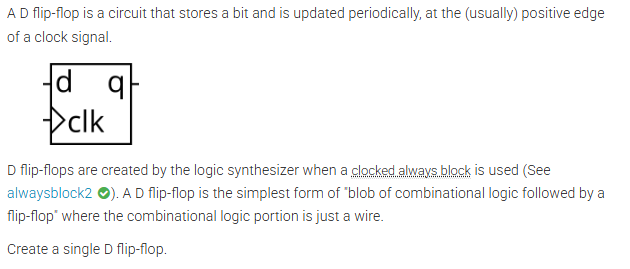

Installing. Please wait... done!


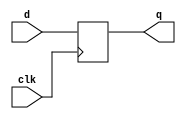

In [ ]:
#DFF
%%print_verilog
module top_module (
    input clk,
    input d,
    output reg q );

    always @(posedge clk)
        q <= d;

endmodule

In [ ]:
%%verilog

//////////////////////////////////////////////////////////
module tb; reg clk_tb, d_tb; wire q_tb;

  parameter CYCLE = 10;

  top_module top(.clk(clk_tb), .d(d_tb), .q(q_tb));

  task dinp(input i);
  begin
    @(negedge clk_tb);
      d_tb = i;
    end
  endtask

  initial begin
    $dumpfile("tb");
    $dumpvars();

    dinp(1);
    dinp(0);
    dinp(0);
    dinp(1);
    # 10 $finish;
  end

  initial clk_tb = 1;
  initial d_tb = 0;

  always begin
    #(CYCLE/10);
    clk_tb = 1;
    #(CYCLE/10);
    clk_tb = 0;
  end
//////////////////////////////////////////////////////////

endmodule

//////////////////////////////////////////////////////////
module top_module (
    input clk,
    input d,
    output reg q );

    always @(posedge clk)
        q <= d;

endmodule
//////////////////////////////////////////////////////////


VCD info: dumpfile tb.vcd opened for output.



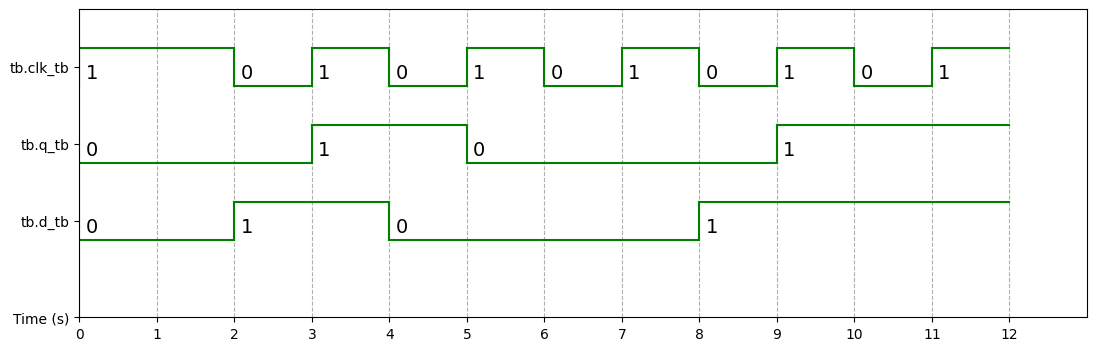

In [ ]:
%%waveform tb.vcd
sign_list = ['tb.clk_tb', 'tb.q_tb','tb.d_tb']
time_begin = 0
time_end = 12
base = 'dec' # bin, dec, dec2, hex, octal

image.png

In [ ]:
#Dff8
%%writefile latchnFF.v
module top_module (
    input clk,
    input [7:0] d,
    output reg [7:0] q
);

    always @(posedge clk)
        q[7:0] <= d[7:0];
endmodule


Overwriting latchnFF.v


In [ ]:
%%writefile tb.v
`timescale 1ns/1ns

module tb;
  reg clk_tb; reg[7:0] d_tb; wire[7:0] q_tb;

  parameter CYCLE = 10;

  top_module top(.clk(clk_tb), .d(d_tb), .q(q_tb));

  task dinp(input[7:0] i);
  begin
    @(posedge clk_tb);
      d_tb = i;
    end
  endtask

  initial begin
    $dumpfile("tb.vcd");
    $dumpvars(0, tb);

    #0 dinp(8'd9);
    #5 dinp(8'd8);
    // Monitor time and output signal
    $monitor("Time = %0t ns | Output = %b", $time, q_tb);
    # 10 $finish;
  end

  initial clk_tb = 1;
  initial d_tb = 0;

  always begin
    #(CYCLE/10);
    clk_tb = 1;
    #(CYCLE/10);
    clk_tb = 0;
  end
  endmodule

Overwriting tb.v


In [ ]:
!iverilog -o tb.out latchnFF.v tb.v
!vvp tb.out

VCD info: dumpfile tb.vcd opened for output.
Time = 9 ns | Output = 00001000


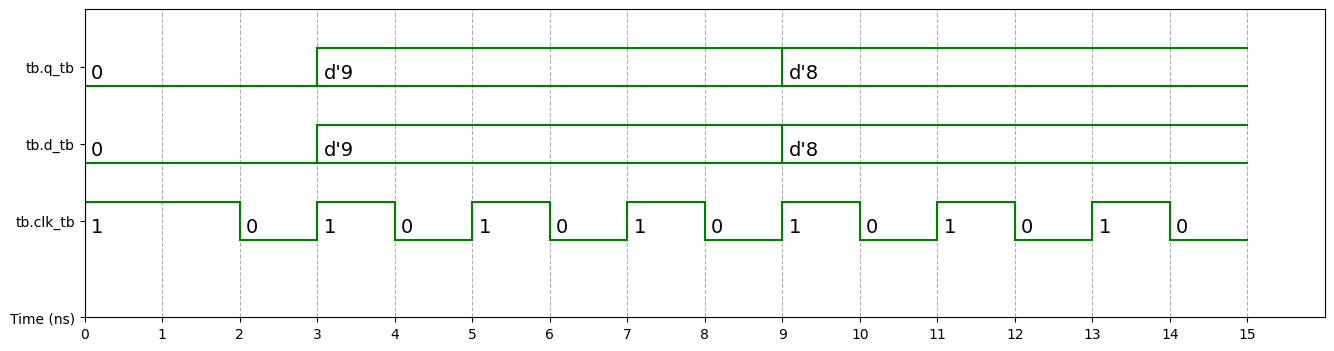

In [ ]:
%%waveform tb.vcd
sign_list = ['tb.q_tb', 'tb.d_tb', 'tb.clk_tb']  # Ensure this matches the signal name in the testbench
time_begin = 0
time_end = 15
base = 'dec'

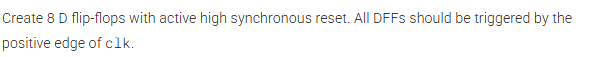

In [ ]:
#Dff8r
%%writefile latchnFF.v
%%print_verilog
module top_module (
    input clk,
    input reset,            // Synchronous reset
    input [7:0] d,
    output reg [7:0] q
);
    always @(posedge clk)
        begin
            if(reset)
                q <= 8'b0;
            else
                q <= d;
        end
endmodule


Overwriting latchnFF.v


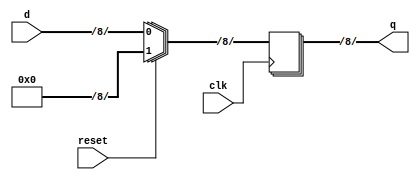

In [ ]:
%%print_verilog
module top_module (
    input clk,
    input reset,            // Synchronous reset
    input [7:0] d,
    output reg [7:0] q
);
    always @(posedge clk)
        begin
            if(reset)
                q <= 8'b0;
            else
                q <= d;
        end
endmodule

In [ ]:
%%writefile tb.v
`timescale 1ns/1ns

module tb;
  reg clk_tb, reset_tb; reg[7:0] d_tb; wire[7:0] q_tb;

  parameter CYCLE = 10;

  top_module top(.clk(clk_tb), .reset(reset_tb), .d(d_tb), .q(q_tb));

  task rst_dut();
    begin
      @(posedge clk_tb);
        reset_tb = 1'b1;
      @(posedge clk_tb);
        reset_tb = 1'b0;
    end
    endtask

  task dinp(input[7:0] i);
  begin
    @(posedge clk_tb);
      d_tb = i;
    end
  endtask

  initial begin
    $dumpfile("tb.vcd");
    $dumpvars(0, tb);


    #0 dinp(8'd9);
    #2 rst_dut;
    #2 dinp(8'd8);
    #2 rst_dut;
    # 2 $finish;
  end

  initial begin
    // Monitor time and output signal
    $monitor("Time = %0t ns | Output = %b", $time, q_tb);
  end

  initial clk_tb = 1;
  initial d_tb = 0;
  initial reset_tb = 0;

  always begin
    #(CYCLE/10);
    clk_tb = 1;
    #(CYCLE/10);
    clk_tb = 0;
  end
  endmodule

Overwriting tb.v


In [ ]:
!iverilog -o tb.out latchnFF.v tb.v
!vvp tb.out

tb.v:10: warning: task definition for "rst_dut" has an empty port declaration list!
VCD info: dumpfile tb.vcd opened for output.
Time = 0 ns | Output = 00000000
Time = 3 ns | Output = 00001001
Time = 5 ns | Output = 00000000
Time = 9 ns | Output = 00001000
Time = 11 ns | Output = 00000000
Time = 15 ns | Output = 00001000


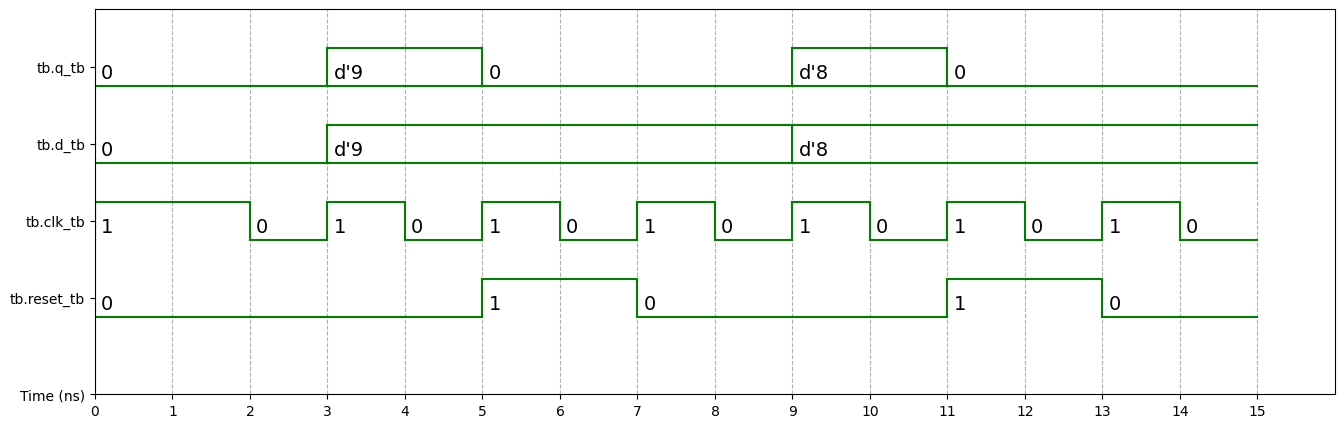

In [ ]:
%%waveform tb.vcd
sign_list = ['tb.q_tb', 'tb.d_tb', 'tb.clk_tb', 'tb.reset_tb']  # Ensure this matches the signal name in the testbench
time_begin = 0
time_end = 15
base = 'dec'